=== Training & Hyper-parameter Tuning (5-fold CV on train) ===

SVR (linear)
Best params: {'reg__C': 1000}
CV best (neg RMSE): -1536008.4799

SVR (rbf)
Best params: {'reg__C': 1000, 'reg__gamma': 0.1}
CV best (neg RMSE): -1782016.9425

SVR (poly)
Best params: {'reg__C': 100, 'reg__degree': 3, 'reg__gamma': 'scale'}
CV best (neg RMSE): -1795189.6606

Ridge (baseline)
Best params: {'reg__alpha': 1}
CV best (neg RMSE): -1029384.1656

Lasso (baseline)
Best params: {'reg__alpha': 0.001}
CV best (neg RMSE): -1029801.7223

=== Test-set Results (sorted by RMSE; lower is better) ===
              Model                                        Best Params  \
0  Lasso (baseline)                              {'reg__alpha': 0.001}   
1  Ridge (baseline)                                  {'reg__alpha': 1}   
2      SVR (linear)                                   {'reg__C': 1000}   
3         SVR (rbf)                {'reg__C': 1000, 'reg__gamma': 0.1}   
4        SVR (poly)  {'reg__C': 100, 'reg__degree

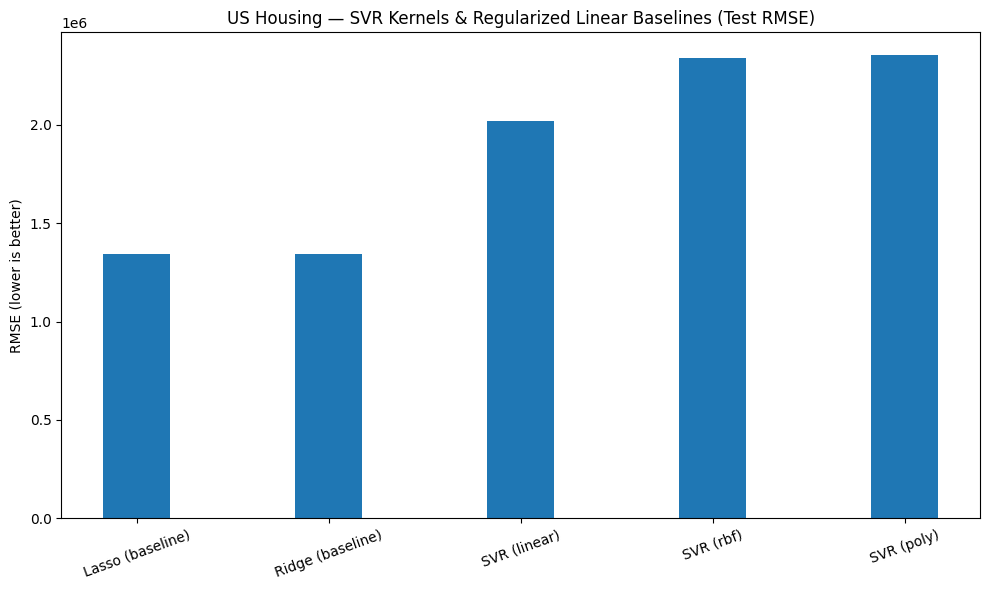

Saved plot: outputs_hw4_p2/p2_metrics_comparison_rmse.png


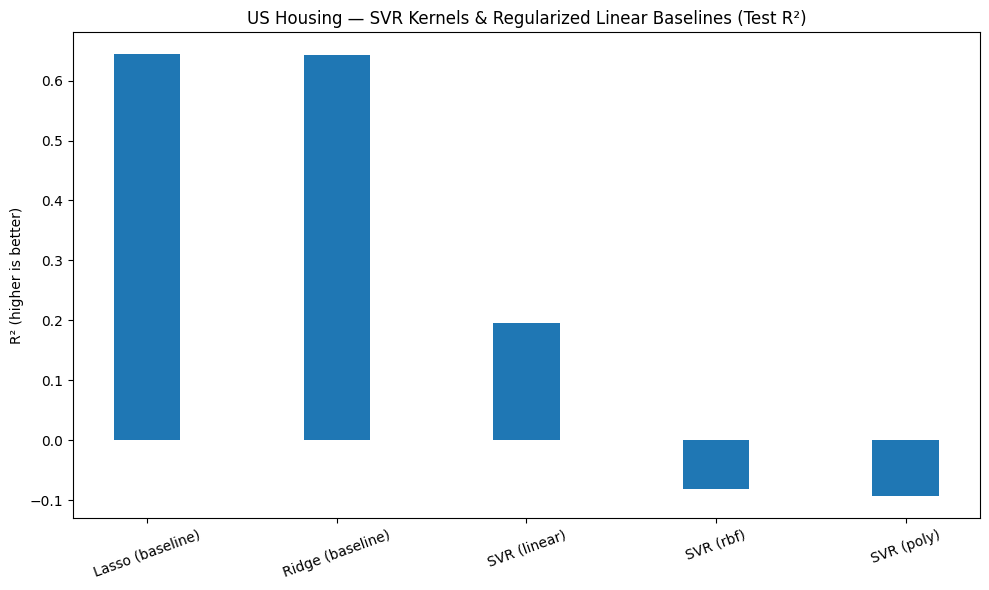

Saved plot: outputs_hw4_p2/p2_metrics_comparison_r2.png


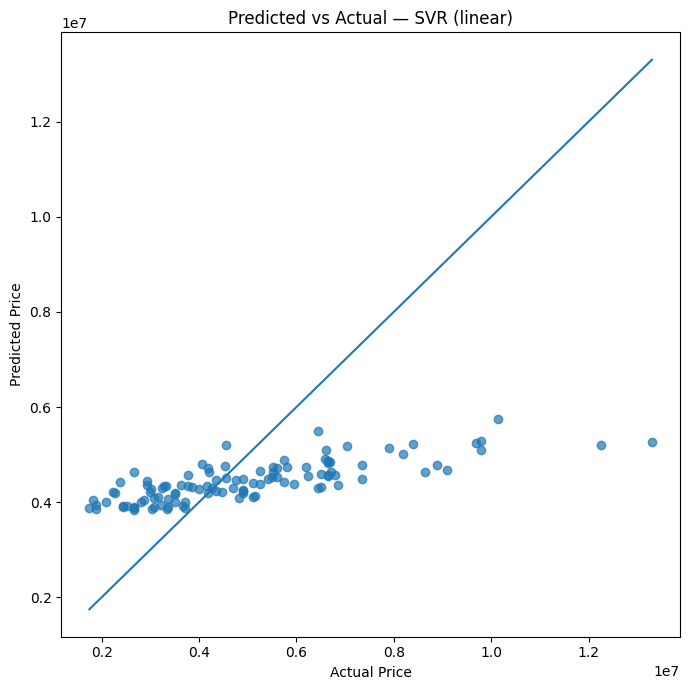

Saved plot: outputs_hw4_p2/p2_pred_vs_actual_SVR_(linear).png


In [2]:
# ============================
# HW4 - Problem 2 (US Housing) — SVR kernels + Ridge/Lasso baselines
# Mohammadmilad Sayyad_801419978
# ============================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ---------- Config ----------
RANDOM_STATE = 42
TEST_SIZE = 0.20
CV_FOLDS = 5
OUT_DIR = "outputs_hw4_p2"
os.makedirs(OUT_DIR, exist_ok=True)

# ---------- Load data ----------
CSV_PATH = "Housing (1).csv"   # change if needed
df = pd.read_csv(CSV_PATH)

# ---------- EXACT Feature Set ----------
FEATURES = [
    "area", "bedrooms", "bathrooms", "stories",
    "mainroad", "guestroom", "basement",
    "hotwaterheating", "airconditioning",
    "parking", "prefarea"
]
TARGET = "price"

missing_cols = [c for c in FEATURES + [TARGET] if c not in df.columns]
if missing_cols:
    raise ValueError(f"Missing required columns in CSV: {missing_cols}")

X = df[FEATURES].copy()
y = df[TARGET].astype(float).copy()

# Categorical columns are yes/no; normalize casing/whitespace
cat_cols = ["mainroad", "guestroom", "basement", "hotwaterheating", "airconditioning", "prefarea"]
for c in cat_cols:
    X[c] = X[c].astype(str).str.strip().str.lower()

num_cols = ["area", "bedrooms", "bathrooms", "stories", "parking"]

# ---------- Split (80/20) ----------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

# ---------- Preprocess (inside ColumnTransformer) ----------
# NOTE: If your sklearn is too old for drop='if_binary', set drop=None instead.
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(drop='if_binary', handle_unknown='ignore'), cat_cols),
    ],
    remainder="drop"
)

# ---------- Helper to evaluate on test (version-proof RMSE) ----------
def eval_regressor(name, estimator, X_te, y_te):
    y_pred = estimator.predict(X_te)
    mse  = mean_squared_error(y_te, y_pred)   # no 'squared' kwarg -> version-proof
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_te, y_pred)
    r2   = r2_score(y_te, y_pred)
    return {"Model": name, "Test_RMSE": rmse, "Test_MAE": mae, "Test_R2": r2, "y_pred": y_pred}

# ---------- CV config ----------
cv = KFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)

# ---------- Define searches ----------
search_specs = []

# SVR - linear
pipe_svr_linear = Pipeline([
    ("prep", preprocess),
    ("reg", SVR(kernel="linear"))
])
grid_svr_linear = {
    "reg__C": [1, 10, 100, 1000],
}
search_specs.append(("SVR (linear)", pipe_svr_linear, grid_svr_linear))

# SVR - rbf
pipe_svr_rbf = Pipeline([
    ("prep", preprocess),
    ("reg", SVR(kernel="rbf"))
])
grid_svr_rbf = {
    "reg__C": [1, 10, 100, 1000],
    "reg__gamma": ["scale", 0.01, 0.1, 1],
}
search_specs.append(("SVR (rbf)", pipe_svr_rbf, grid_svr_rbf))

# SVR - poly
pipe_svr_poly = Pipeline([
    ("prep", preprocess),
    ("reg", SVR(kernel="poly"))
])
grid_svr_poly = {
    "reg__C": [1, 10, 100],
    "reg__degree": [2, 3],
    "reg__gamma": ["scale", 0.01, 0.1],
}
search_specs.append(("SVR (poly)", pipe_svr_poly, grid_svr_poly))

# Ridge baseline
pipe_ridge = Pipeline([
    ("prep", preprocess),
    ("reg", Ridge())
])
grid_ridge = {
    "reg__alpha": [0.001, 0.01, 0.1, 1, 10, 100]
}
search_specs.append(("Ridge (baseline)", pipe_ridge, grid_ridge))

# Lasso baseline
pipe_lasso = Pipeline([
    ("prep", preprocess),
    ("reg", Lasso(max_iter=10000))
])
grid_lasso = {
    "reg__alpha": [0.001, 0.01, 0.1, 1, 10, 100]
}
search_specs.append(("Lasso (baseline)", pipe_lasso, grid_lasso))

# ---------- Run GridSearchCV and evaluate ----------
all_results = []
best_estimators = {}
print("=== Training & Hyper-parameter Tuning (5-fold CV on train) ===")
for name, pipe, grid in search_specs:
    gs = GridSearchCV(
        estimator=pipe,
        param_grid=grid,
        cv=cv,
        scoring="neg_root_mean_squared_error",  # primary metric = RMSE (negated)
        n_jobs=-1,
        refit=True,
        verbose=0
    )
    gs.fit(X_train, y_train)
    best_estimators[name] = gs.best_estimator_

    print(f"\n{name}")
    print("Best params:", gs.best_params_)
    print("CV best (neg RMSE): {:.4f}".format(gs.best_score_))

    # Evaluate on test set
    res = eval_regressor(name, gs.best_estimator_, X_test, y_test)
    all_results.append({
        "Model": name,
        "Best Params": gs.best_params_,
        "Test_RMSE": res["Test_RMSE"],
        "Test_MAE": res["Test_MAE"],
        "Test_R2": res["Test_R2"]
    })

# ---------- Results table ----------
results_df = pd.DataFrame(all_results).sort_values("Test_RMSE", ascending=True).reset_index(drop=True)
print("\n=== Test-set Results (sorted by RMSE; lower is better) ===")
print(results_df)

# Save CSV
csv_path = os.path.join(OUT_DIR, "p2_results_summary.csv")
results_df.to_csv(csv_path, index=False)
print(f"\nSaved results table to: {csv_path}")

# ---------- Plots: Kernel/baseline comparison ----------
labels = results_df["Model"].tolist()
rmse = results_df["Test_RMSE"].values
r2   = results_df["Test_R2"].values
x = np.arange(len(labels))
bar_w = 0.35

# RMSE bar chart (primary)
plt.figure(figsize=(10,6))
plt.bar(x, rmse, width=bar_w)
plt.xticks(x, labels, rotation=20)
plt.ylabel("RMSE (lower is better)")
plt.title("US Housing — SVR Kernels & Regularized Linear Baselines (Test RMSE)")
plt.tight_layout()
rmse_plot_path = os.path.join(OUT_DIR, "p2_metrics_comparison_rmse.png")
plt.savefig(rmse_plot_path, dpi=200)
plt.show()
print(f"Saved plot: {rmse_plot_path}")

# R² bar chart (secondary)
plt.figure(figsize=(10,6))
plt.bar(x, r2, width=bar_w)
plt.xticks(x, labels, rotation=20)
plt.ylabel("R² (higher is better)")
plt.title("US Housing — SVR Kernels & Regularized Linear Baselines (Test R²)")
plt.tight_layout()
r2_plot_path = os.path.join(OUT_DIR, "p2_metrics_comparison_r2.png")
plt.savefig(r2_plot_path, dpi=200)
plt.show()
print(f"Saved plot: {r2_plot_path}")

# ---------- Predicted vs Actual for the best SVR ----------
svr_mask = results_df["Model"].str.startswith("SVR")
best_svr_name = results_df[svr_mask].iloc[0]["Model"]
best_svr = best_estimators[best_svr_name]
y_pred_best = best_svr.predict(X_test)

plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred_best, alpha=0.7)
mn = min(y_test.min(), y_pred_best.min())
mx = max(y_test.max(), y_pred_best.max())
plt.plot([mn, mx], [mn, mx])  # y = x
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title(f"Predicted vs Actual — {best_svr_name}")
plt.tight_layout()
pva_path = os.path.join(OUT_DIR, f"p2_pred_vs_actual_{best_svr_name.replace(' ', '_')}.png")
plt.savefig(pva_path, dpi=200)
plt.show()
print(f"Saved plot: {pva_path}")
